In [26]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.stats import gaussian_kde

from src import plot_Hubble_marginal

# Set Plotting Style
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "text.usetex": False,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

# **Cosmological Inference**

- In the previous notebook we obtained posterior samples for the Parameters: RA, Dec, $\psi$, $t^{(geo)}_c$ and $D_l$.
- In this notebook we use these posterior estimates to localise the Gravitational Waves Source in the Sky and estimate the Hubble Constant using a mock galaxy dataset.

In [27]:
## Load the Posterior Samples form the Nested Sampling Run
H1_L1_samples =  np.load("results/NS_posterior_samples_H1_L1.npy")
H1_L1_V1_samples =  np.load("results/NS_posterior_samples_H1_L1_V1.npy")

## Load the Mock Catalog
galaxy_catalog = pd.read_csv("data/Catalog/mock_galaxy_catalog.txt", sep=r"\s+", comment="#", header=None, names=["name", "ra", "dec", "z"])


## Determine the Confidence Regions of Sky Map
- For a given confidence level we wish to determine the area do the sky (2D: RA and Dec) which we can attribute the signal to.

## **Approach 1:** 1D Marginal Confidence Regions (Not ideal or accurate):
- We can use the 1D marginal confidence intervals for RA and Dec indepdently
- Assign the overlap of these regions as the approximate “confidence region” in 2D.
- **Limitation:** Does no account for the correlation between RA and Dec --  potentially under- or over-estimating the true confidence region

## **Approach 2:** KDE Countours (More riguorus and Preffered)
- Create a **2D Gaussian KDE** distribution from the grid of posterior samples in RA and Dec space.
- Evaluate the KDE on a dense grid of points to approximate the posterior density function.
- Compute the **threshold** density value:
    -  the integrated probability above this threshold equals the desired confidence level.
- Define a contour at this threshold density

$$
\iint_{p(x, y) \geq p_{\mathrm{th}}} p(x, y) \, dx \, dy = \alpha
$$

Where:
- $ \alpha \in (0, 1) $ is the desired confidence level

## **Hubble Constant Inference**
Once we have isolated potential host galaxies we can use there measured redshifts to determine the Hubble Constant, this is done simply using Hubble's Law:

$$
v = H_0 \, D_L
$$

**Where:**
- v is the recession velocity of the host galaxy ($v \approx c \cdot z$ for low redshift z),

**Thus:**
$$
z = \frac{\lambda_o}{\lambda_e} - 1 
  = \sqrt{\frac{1 + \frac{v}{c}}{1 - \frac{v}{c}}} - 1 
  \approx \frac{v}{c}
$$

$$
H_0 = \frac{c \cdot z}{D_L}
$$

## **Caveat:**
- The linear approximation defined above is an approximation for the following at **low redshift**:
$$
d_L = (1 + z) \, r_1 \approx \frac{c}{H_0} \left[ z + \frac{1}{2}(1 - q_0) z^2 + \cdots \right]
$$
- $ d_L $ is the **luminosity distance**
- $ r_1 $ is the **comoving distance**
- $ q_0 $ is the **deceleration parameter**
- $ c $ is the **speed of light**

However, this linear approximation is **inaccurate at higher redshift**, where cosmic acceleration and curvature must be considered.


In [28]:
def catalog_analysis(samples, catalog, confidence_level=0.9, title = 'Galaxy Catalogue Comparison: H1 and L1', colors = ['red','blue'], grid_size=100):
    """
    Estimate and visualize a 2D KDE confidence contour from posterior samples, identify matching catalog sources,
    compute inferred Hubble constant values, and generate a detailed summary plot.

    Parameters
    ----------
    samples : np.ndarray
        Posterior samples of shape (N, >=5), with Right Ascension in column 0, Declination in column 1,
        and luminosity distance in column 4 (in Gpc).
    catalog : pd.DataFrame
        Galaxy catalog with columns: 'name', 'ra', 'dec', and 'z'.
        RA and Dec must be in radians; redshift 'z' is dimensionless.
    colors : list of str
        A list of two colors used in plotting: one for the contour and matching galaxies,
        and one for the 1D confidence interval lines and secondary matches.
    confidence_level : float, optional
        Confidence level to define the contour and 1D percentile intervals (default is 0.9).
    grid_size : int, optional
        Resolution of the KDE evaluation grid (default is 100).

    Returns
    -------
    None
        The function prints two summary tables of catalog galaxies inside the 1D and 2D confidence regions,
        adds Hubble constant and uncertainty estimates to the catalog, and produces a 2D sky map
        showing the KDE contour, posterior sample histogram, galaxy matches, and annotations.
    """

    ra_samples = samples[:, 0]
    dec_samples = samples[:, 1]
    dl_samples = samples[:, 4]
    data = np.vstack([ra_samples, dec_samples])

    # ======= Hubble constant =======
    # Determine the Dl Median Values and the Uncertainty (in GPc)
    speed_of_light = 299792.458  # km/s

    H0_medians = []
    H0_lowers = []
    H0_uppers = []

    for z in catalog['z']:
        H0 = speed_of_light * z / (dl_samples *1000) # Convert Gpc to Mpc
        H0_medians.append(np.median(H0))
        H0_lowers.append(np.median(H0)- np.percentile(H0, 16))
        H0_uppers.append(np.percentile(H0, 84) - np.median(H0))

    catalog['H0'] = H0_medians
    catalog['H0_uncert'] = [f"{low:.2f}–{high:.2f}" for low, high in zip(H0_lowers, H0_uppers)]
    ## ======= 1D confidence intervals =======

    # Find the 1D confidence intervals for RA and Dec
    ra_lower = np.percentile(ra_samples, (1 - confidence_level) * 100 / 2)
    ra_upper = np.percentile(ra_samples, (1 + confidence_level) * 100 / 2)
    dec_lower = np.percentile(dec_samples, (1 - confidence_level) * 100 / 2)
    dec_upper = np.percentile(dec_samples, (1 + confidence_level) * 100 / 2)

    # Find the Catalog points that are within the 1D confidence intervals
    ra_mask = (catalog['ra'] >= ra_lower) & (catalog['ra'] <= ra_upper)
    dec_mask = (catalog['dec'] >= dec_lower) & (catalog['dec'] <= dec_upper)
    catalog_mask_1d = ra_mask & dec_mask
    catalog_1d = catalog[catalog_mask_1d].copy()
    
    ## ======= 2D KDE Confidence Contour =======
    
    # Calculate the Gaussian KDE distribution
    kde = gaussian_kde(data)

    # Create a grid for the KDE to be evaluated on
    x = np.linspace(ra_samples.min(), ra_samples.max(), grid_size)
    y = np.linspace(dec_samples.min(), dec_samples.max(), grid_size)
    X, Y = np.meshgrid(x, y)

    # Evaluate the KDE on the grid
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_grid_values = kde(positions).reshape(X.shape)
    kde_grid_values_flat = kde_grid_values.flatten()

    # Calculate the contour level for the specified confidence level
    kde_grid_values_sorted = np.sort(kde_grid_values_flat)[::-1]
    # Normalize the KDE values
    total_kde = np.cumsum(kde_grid_values_sorted)
    total_kde /= total_kde[-1]
    threshold_idx = np.searchsorted(total_kde, confidence_level)
    density_threshold = kde_grid_values_sorted[threshold_idx]

    # Find the Catalog points that are within the 2D countour intervals
    kde_values_catalog = kde(catalog[['ra', 'dec']].T)
    inside_mask = kde_values_catalog >= density_threshold
    catalog_mask_2d = inside_mask.flatten()
    catalog_2d = catalog[catalog_mask_2d].copy()


    # ======= Printing the results =======

    # Printing summary table of the Catalog points inside the 1D confidence intervals (orded by probability density)
    # Calculate the KDE values for the catalog points
    kde_values_catalog_1d = kde(catalog_1d[['ra', 'dec']].T)
    catalog_1d.loc[:, 'kde_value'] = kde_values_catalog_1d
    catalog_1d = catalog_1d.sort_values(by='kde_value', ascending=False)
    # Account for if empty catalog_1d
    print("Galaxy Matches inside the 1D confidence intervals:")
    if catalog_1d.empty:
        print("No galaxies found within the 1D confidence intervals.")
    else:
        print(catalog_1d[['name', 'ra', 'dec', 'z', 'H0', 'H0_uncert', 'kde_value']].round(3))


    # Printing summary table of the Catalog points inside the 2D confidence contour (orded by probability density)
    # Calculate the KDE values for the catalog points
    kde_values_catalog_2d = kde(catalog_2d[['ra', 'dec']].T)
    catalog_2d.loc[:, 'kde_value'] = kde_values_catalog_2d
    catalog_2d = catalog_2d.sort_values(by='kde_value', ascending=False)
    print("Galaxy Matches inside the 2D confidence contour:")
    if catalog_2d.empty:
        print("No galaxies found within the 2D confidence contour.")
    else:
        print(catalog_2d[['name', 'ra', 'dec', 'H0', 'H0_uncert', 'kde_value']].round(3))


    # Remove the values from 1D confidence intervals that are also in the 2D confidence contour
    filtered_catalog = catalog_1d[~catalog_1d.index.isin(catalog_2d.index)].copy()
    filtered_catalog.loc[:, 'kde_value'] = kde_values_catalog_1d[~catalog_1d.index.isin(catalog_2d.index)]

    # Remove the values from the overall catalog that are in the 1D and 2D confidence intervals
    catalog_mask = ~catalog.index.isin(catalog_1d.index) & ~catalog.index.isin(catalog_2d.index)
    catalog_full = catalog[catalog_mask].copy()
    catalog_full.loc[:, 'kde_value'] = kde(catalog_full[['ra', 'dec']].T)
    
    # Plotting the results
    # Convert all RA and Dec values to degrees for plotting
    X = np.degrees(X)
    Y = np.degrees(Y)
    ra_samples = np.degrees(ra_samples)
    dec_samples = np.degrees(dec_samples)
    ra_lower = np.degrees(ra_lower)
    ra_upper = np.degrees(ra_upper)
    dec_lower = np.degrees(dec_lower)
    dec_upper = np.degrees(dec_upper)
    catalog_full['ra'] = np.degrees(catalog_full['ra'])
    catalog_full['dec'] = np.degrees(catalog_full['dec'])
    catalog_1d['ra'] = np.degrees(catalog_1d['ra'])
    catalog_1d['dec'] = np.degrees(catalog_1d['dec'])
    catalog_2d['ra'] = np.degrees(catalog_2d['ra'])
    catalog_2d['dec'] = np.degrees(catalog_2d['dec'])
    filtered_catalog['ra'] = np.degrees(filtered_catalog['ra'])
    filtered_catalog['dec'] = np.degrees(filtered_catalog['dec'])

    fig, ax = plt.subplots(figsize=(6, 4))

    # Underlying faint histogram of the samples
    ax.hist2d(ra_samples, dec_samples, bins=grid_size, cmap='Greys', alpha=0.8, density=True)
    contour = ax.contour(X, Y, kde_grid_values, levels=[density_threshold], colors=colors[0], linewidths=2)
    contour_proxy = Line2D([], [], color=colors[0], linewidth=1, label=f'{confidence_level*100:.0f}% Contour')

    ax.set_xlabel("Right Ascension", fontsize=12)
    ax.set_ylabel("Declination", fontsize=12)
    ax.grid(True)

    # Median lines for RA and Dec
    ax.axvline(np.median(ra_samples), color=colors[1], linestyle='-', linewidth=1.1, label=f'Median ± {confidence_level*50}% percentiles')
    ax.axhline(np.median(dec_samples), color=colors[1], linestyle='-', linewidth=1.1)

    # 1D confidence intervals as dashed lines
    ax.axvline(ra_lower, color=colors[1], linestyle='--', linewidth=1)
    ax.axvline(ra_upper, color=colors[1], linestyle='--', linewidth=1)
    ax.axhline(dec_lower, color=colors[1], linestyle='--', linewidth=1)
    ax.axhline(dec_upper, color=colors[1], linestyle='--', linewidth=1)

    # Plot catalog points
    # Plot catalog matches (and non matches)
    ax.scatter(catalog_2d['ra'], catalog_2d['dec'], color=colors[0], edgecolor='black', label=f'Galaxy Match - Contour', s=20, marker='s', zorder=10)
    ax.scatter(filtered_catalog['ra'], filtered_catalog['dec'], color=colors[1], edgecolor='black', label=f'Galaxy Match - 1D limits', s=20, marker='s', zorder=11)
    ax.scatter(catalog_full['ra'], catalog_full['dec'], color='grey', edgecolor='black', alpha=0.5, s=30, marker='s', zorder=9)

    # Label those countour matches by name with text
    for i, row in catalog_2d.iterrows():
        ax.text(row['ra'], row['dec'], row['name'], fontsize=8, ha='right', va='bottom', color='black', weight="bold", zorder=12)

    handles, labels = ax.get_legend_handles_labels()
    handles = [contour_proxy] + handles
    labels = [contour_proxy.get_label()] + labels
    legend = ax.legend(handles=handles, labels=labels,
          loc='upper left', bbox_to_anchor=(0.02, 0.92), fontsize=8, framealpha=1)
    legend.set_zorder(15)  #

    ax.text(0.02, 0.98, title,
            transform=ax.transAxes,
            fontsize=12,
            ha='left', va='top',
            bbox=dict(facecolor='white', edgecolor='black'), zorder=13)
    

    # Add degree symbols to marginal plots
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f"{tick:.1f}°" for tick in ax.get_xticks()])
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([f"{tick:.1f}°" for tick in ax.get_yticks()])


    ax.set_xlim(ra_lower - 0.5*(ra_upper - ra_lower), ra_upper + 0.5*(ra_upper - ra_lower))
    ax.set_ylim(dec_lower - 0.5*(dec_upper - dec_lower), dec_upper + 0.5*(dec_upper - dec_lower))

    plt.show()
    return catalog_2d

## **90% Confindence Level of H1 and L1 Posterior**

Galaxy Matches inside the 1D confidence intervals:
            name     ra    dec      z       H0    H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  0.226   65.435    2.87–3.59      5.988
240  MGC+JGS5HZS  2.543 -0.969  0.797  230.759  10.11–12.65      2.374
353  MGC+J2DG22T  1.993 -1.219  1.807  523.189  22.92–28.69      0.899
244  MGC+J374SHJ  2.550 -1.195  1.702  492.788  21.59–27.02      0.002
493  MGC+JS71A6E  2.624 -1.213  1.177  340.782  14.93–18.69      0.000
Galaxy Matches inside the 2D confidence contour:
            name     ra    dec      H0  H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  65.435  2.87–3.59      5.988


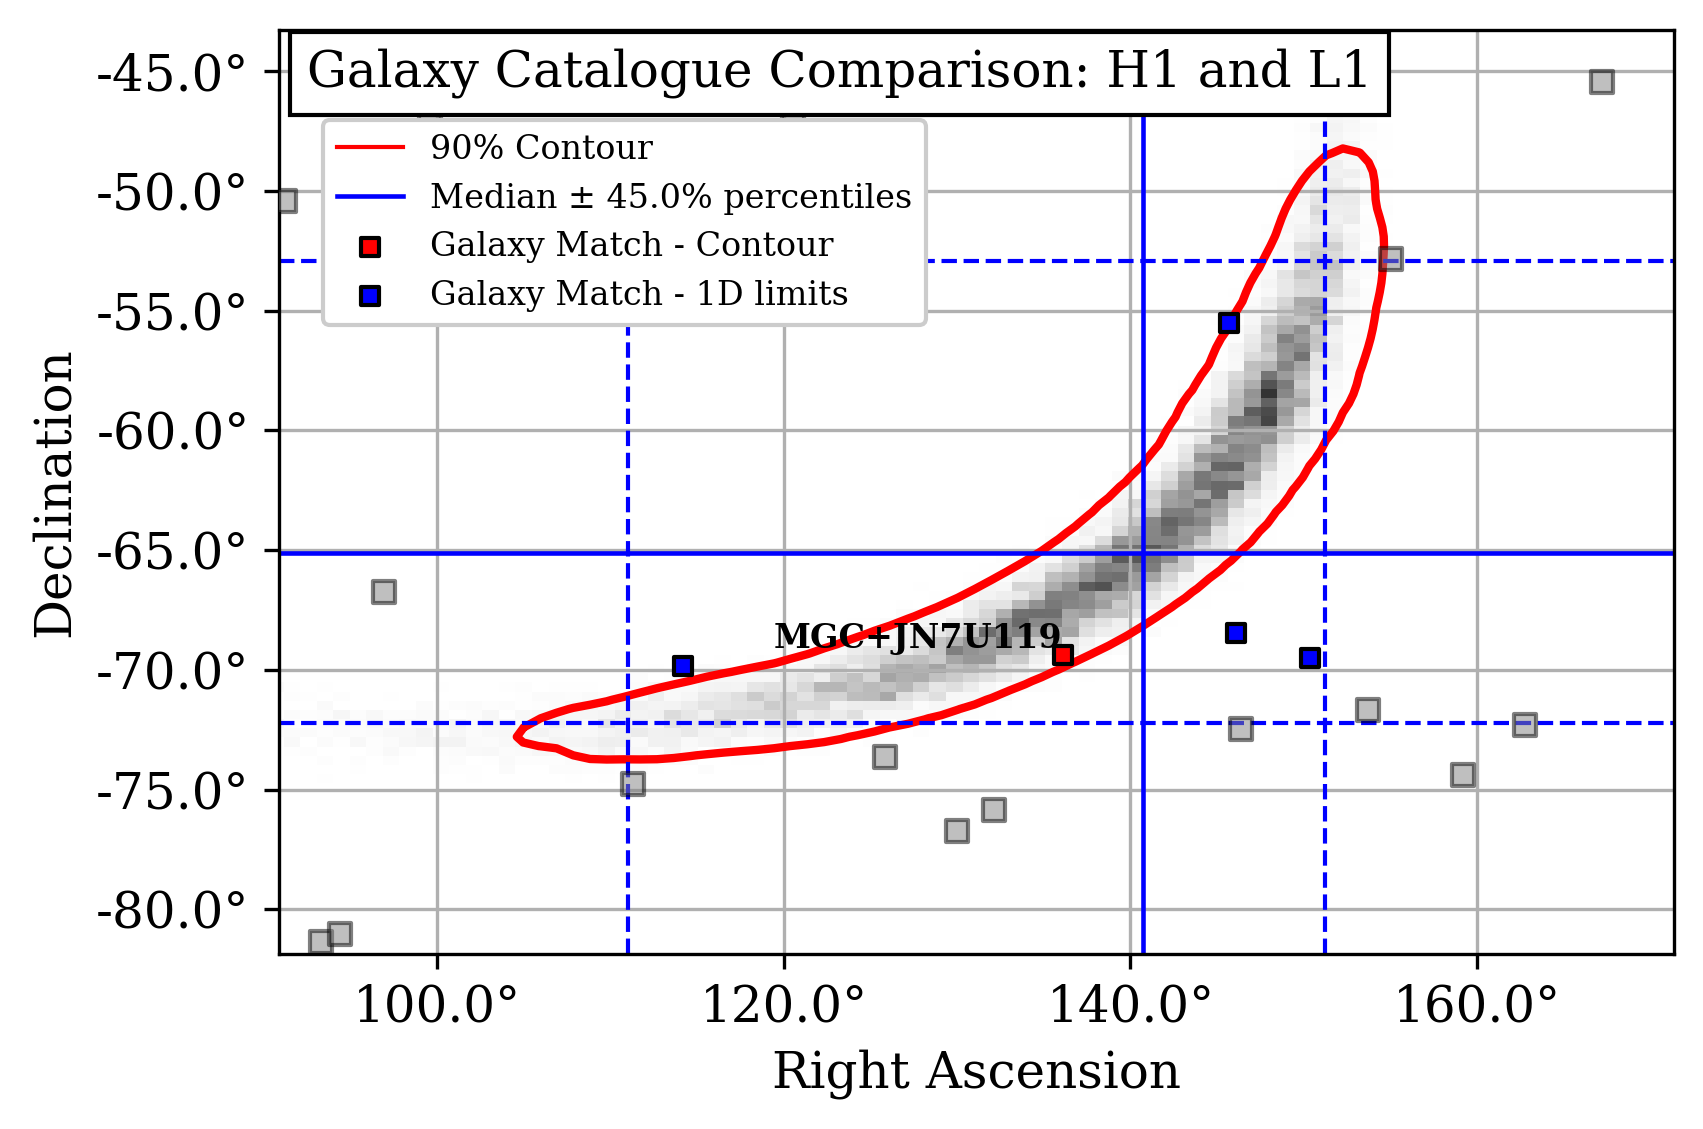

In [38]:
filtered_catalog_2detector = catalog_analysis(H1_L1_samples, galaxy_catalog, confidence_level=0.9)

## **96.5% Confindence Level of H1 and L1 Posterior**

Galaxy Matches inside the 1D confidence intervals:
            name     ra    dec      z       H0    H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  0.226   65.435    2.87–3.59      5.988
240  MGC+JGS5HZS  2.543 -0.969  0.797  230.759  10.11–12.65      2.374
353  MGC+J2DG22T  1.993 -1.219  1.807  523.189  22.92–28.69      0.899
244  MGC+J374SHJ  2.550 -1.195  1.702  492.788  21.59–27.02      0.002
493  MGC+JS71A6E  2.624 -1.213  1.177  340.782  14.93–18.69      0.000
152  MGC+JTNEMMF  2.555 -1.265  0.889  257.396  11.28–14.11      0.000
242  MGC+J9XA4WY  1.937 -0.899  1.883  545.193  23.89–29.89      0.000
Galaxy Matches inside the 2D confidence contour:
            name     ra    dec       H0    H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211   65.435    2.87–3.59      5.988
240  MGC+JGS5HZS  2.543 -0.969  230.759  10.11–12.65      2.374
274  MGC+J07PCIH  2.706 -0.922  438.355  19.21–24.04      1.733
353  MGC+J2DG22T  1.993 -1.219  523.189  22.92–28.69      0.899


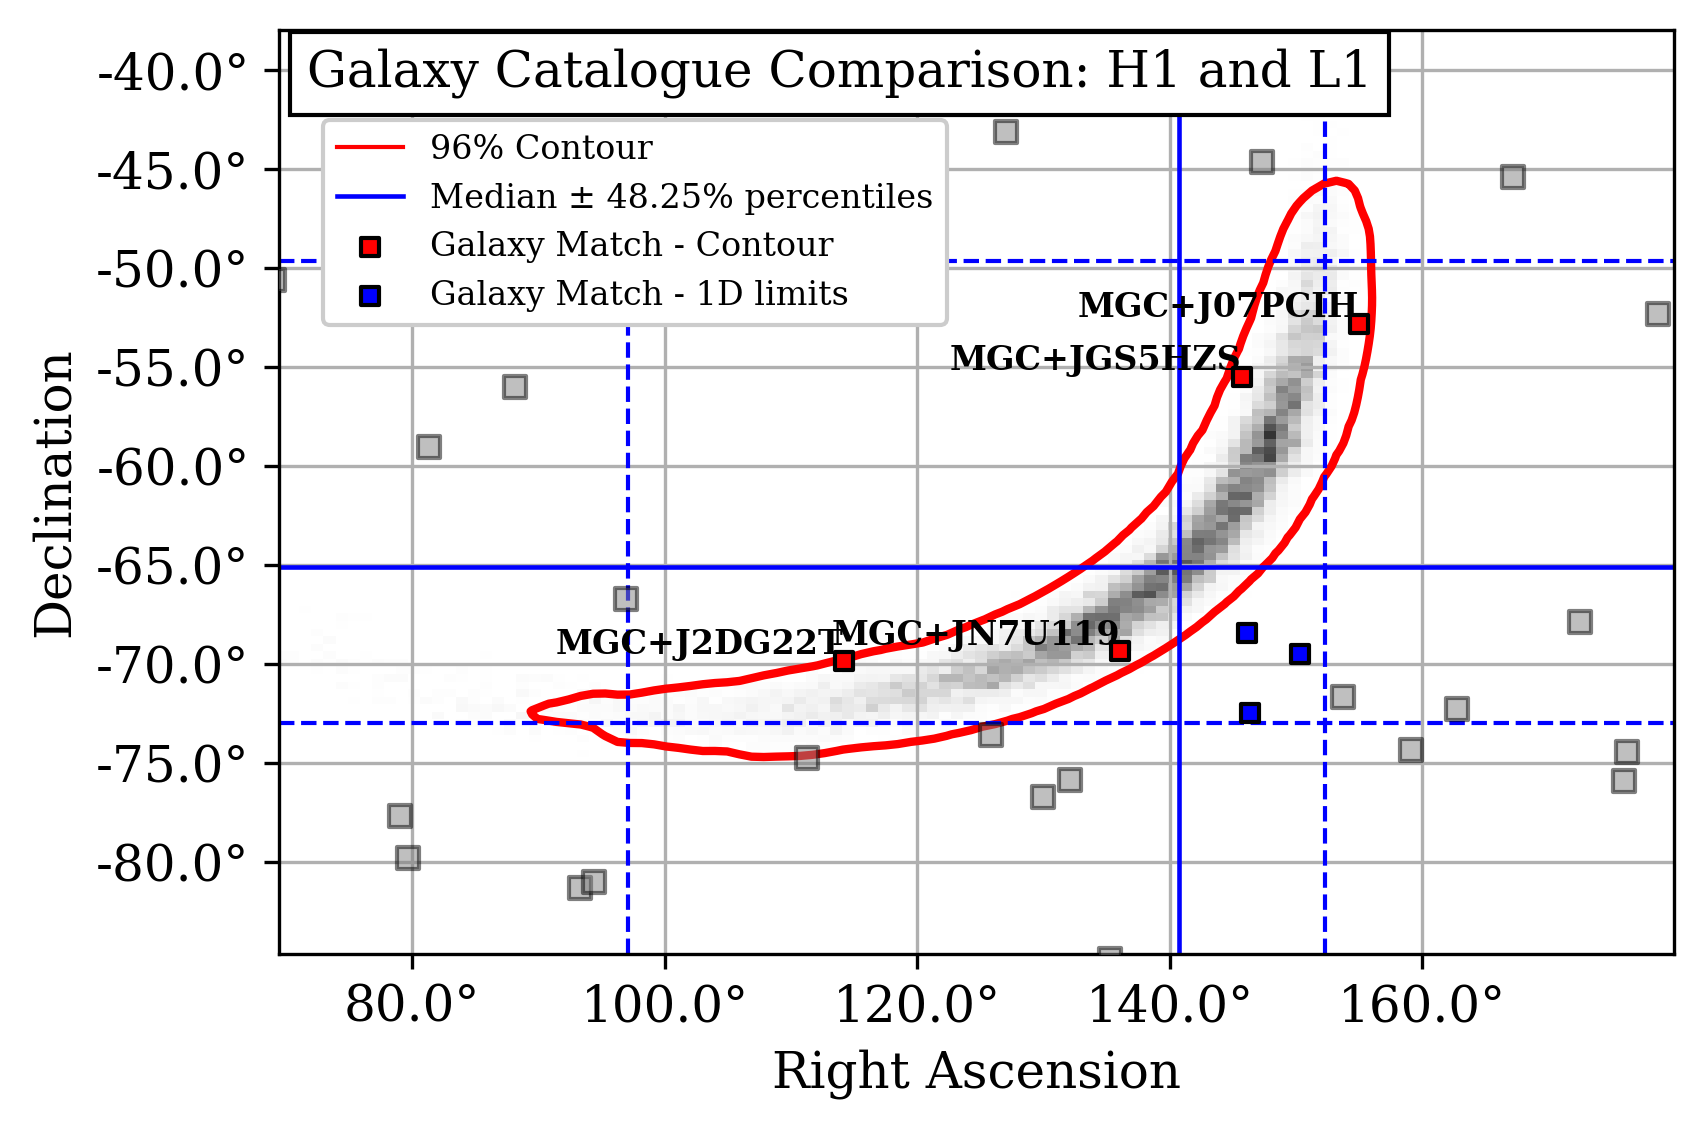

In [39]:
filtered_catalog_2detector = catalog_analysis(H1_L1_samples, galaxy_catalog, confidence_level=0.965)

## **90% Confindence Level of H1, L1 and V1 Posterior**

Galaxy Matches inside the 1D confidence intervals:
No galaxies found within the 1D confidence intervals.
Galaxy Matches inside the 2D confidence contour:
            name     ra    dec      H0  H0_uncert  kde_value
497  MGC+JN7U119  2.375 -1.211  66.789  2.19–2.27    129.871


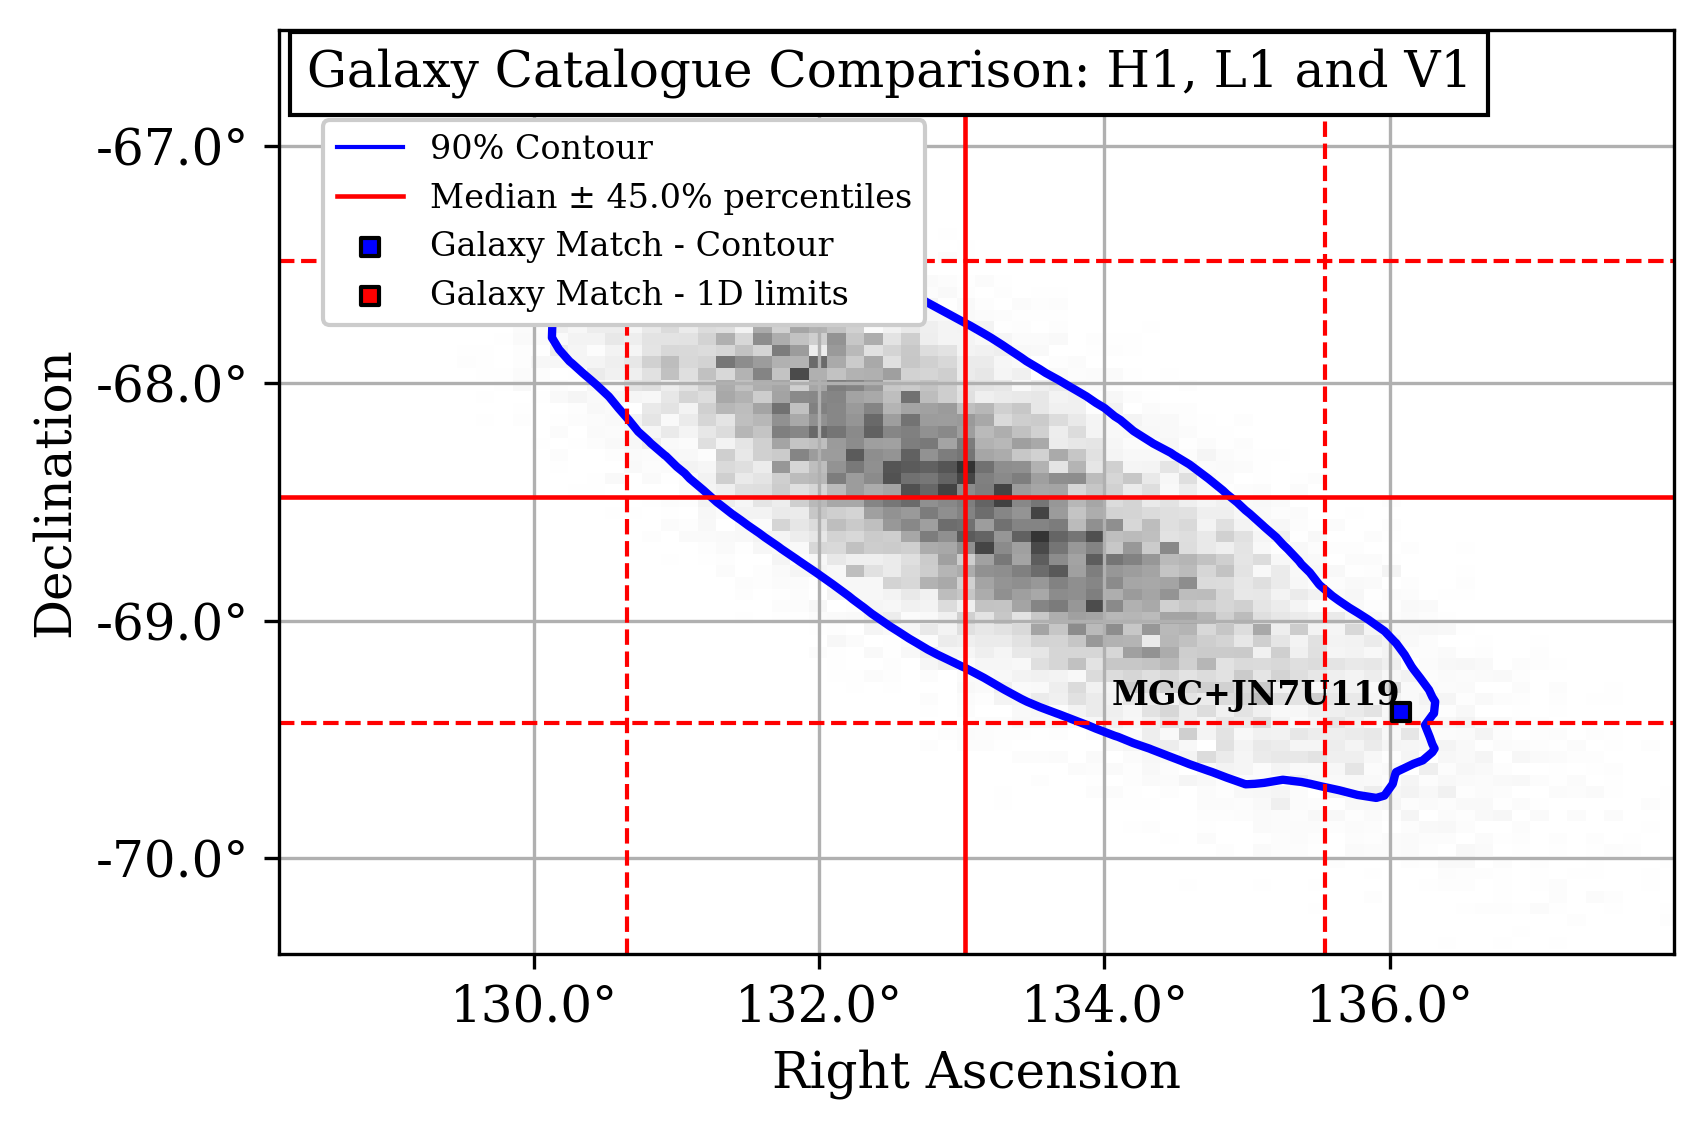

In [34]:
filtered_catalog_3detector = catalog_analysis(H1_L1_V1_samples, galaxy_catalog, confidence_level=0.9, title= 'Galaxy Catalogue Comparison: H1, L1 and V1', colors= ['blue', 'red'])

## **Corrolation between RA/ Dec and $D_l$?**
- In the above analysis we have assumed that the luminosity distance and its marginal distribution are uncorrolated to RA and Dec which is supported by the distribution corner plots apearing to be uncorrolated in the dimensions and of RA and Dec, this is because $D_l$ simply changes the scaling of the RA and Dec.
- Therefore we do not need to account for this given the fixed position of RA and Dec


## **Histogram of Hubble Constant**


/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:792: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(lower, upper, color=color, alpha=0.1, hatch='///', edgecolor=color)
/Users/jacobtutt/Desktop/MPhil_DIS/Grav_Waves/GravitationalWavesCW/src/posterior_plotting.py:794: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(lower, upper, color=color, alpha=0.1, hatch='\\\\', edgecolor=color)


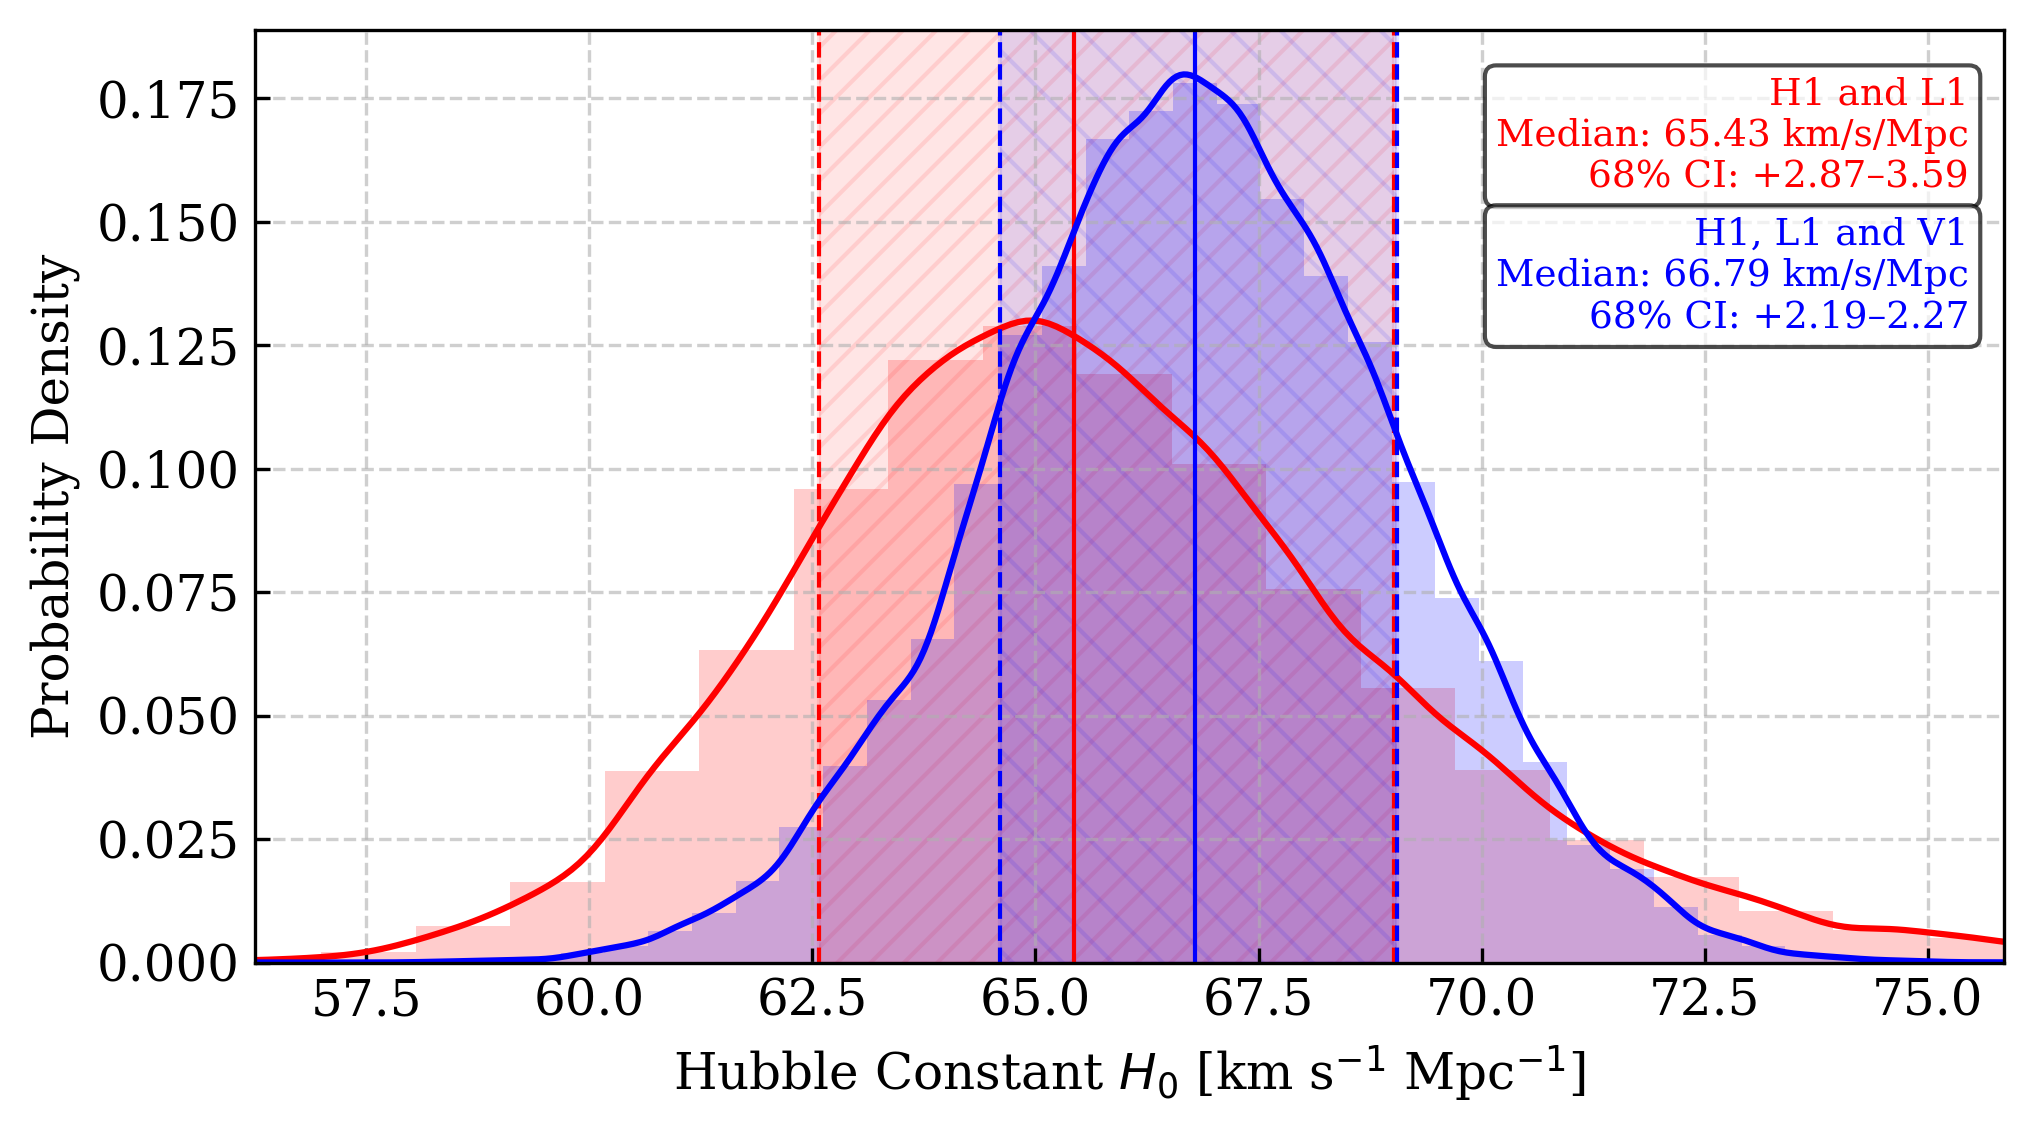

In [25]:
plot_Hubble_marginal(H1_L1_samples, H1_L1_V1_samples, filtered_catalog_3detector['z'].values)